# IQ Constellation Data Explore
This Notebook explores the following approach
1. Apply KMeans Clustering to map blobs to clusters
2. Extract Blob Shape by applying Covariance Error Ellipse
3. Plot new metrics next to raw blob plot
4. Use statistical methods to determine Interference/Phase Noise/Amplifier Gain Noise
5. Write report to S3

A next step to this solution could be applying a Decision Tree Classifier to make an inference based on the shape metrics extracted from Covariance Error Ellipse

Data Science ml.t3.medium

In [4]:
!conda update -y conda

import sagemaker
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import time
import os
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse
from matplotlib.path import Path
from time import gmtime, strftime
import io

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [5]:
# Constants
STD_DEV = 2.5

## Extract Blob Shape Metrics, Covariance Error Ellipse

In [6]:
def confidence_ellipse(x, y, n_std=3.0):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    covariance = np.cov(x, y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    center = (mean_x, mean_y)    
    
     # Calculate eigenvectors and eigenvalues of covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance)

    # Sort eigenvectors by decreasing eigenvalues
    order = eigenvalues.argsort()[::-1]
    eigenvectors = eigenvectors[:, order]   
    
    
    # Calculate major and minor axes lengths
    major_length = np.sqrt(eigenvalues[order[0]]) * n_std
    minor_length = np.sqrt(eigenvalues[order[1]]) * n_std

    # Calculate major and minor axes angles
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # Plot data and ellipse
    ellipse = Ellipse(center, width=major_length*2,
                  height=minor_length*2, angle=angle, fill=False)  
    
    major_axis = eigenvectors[:, 0] * major_length
    minor_axis = eigenvectors[:, 1] * minor_length

    distance_major = np.sqrt(mean_x**2 * np.sin(angle)**2 + mean_y**2 * np.cos(angle)**2)
    distance_minor = np.sqrt(mean_x**2 * np.cos(angle)**2 + mean_y**2 * np.sin(angle)**2)

    # Count the number of points within the Ellipse
    path = Path(ellipse.get_verts())
    points = np.column_stack((x, y))
    num_inside = 0
    for point in points:
        if path.contains_point(point):
            num_inside += 1

    # Compute point density
    area = np.pi * major_length * minor_length
    density = num_inside / area
    
    return {"ellipse": ellipse, "major_axis": major_axis, "minor_axis": minor_axis, "center": center, "density": density, "ratio": (major_length/minor_length), "axis": (distance_major < distance_minor)}

## Determine Orientation of Major/Minor Axis

In [7]:
# Check which line is closer to a given point
def line_distance(l1, l2, p):
    # Define the points
    P1 = p
    pa = l1[0]
    pb = l1[1]
    pc = l2[0]
    pd = l2[1]

    # Calculate the distances to the infinite lines
    dist_L1 = abs((pb[1]-pa[1])*P1[0] - (pb[0]-pa[0])*P1[1] + pb[0]*pa[1] - pb[1]*pa[0]) / ((pb[1]-pa[1])**2 + (pb[0]-pa[0])**2)**0.5
    dist_L2 = abs((pd[1]-pc[1])*P1[0] - (pd[0]-pc[0])*P1[1] + pd[0]*pc[1] - pd[1]*pc[0]) / ((pd[1]-pc[1])**2 + (pd[0]-pc[0])**2)**0.5
    
    # Extend the lines infinitely
    x = np.linspace(-10, 10, 100)
    y1 = (pb[1]-pa[1])/(pb[0]-pa[0])*(x-pa[0])+pa[1]
    y2 = (pd[1]-pc[1])/(pd[0]-pc[0])*(x-pc[0])+pc[1]
    # Print the results
    # if dist_L1 < dist_L2:
    #     print("Line L1 is closer to point P1.")
    # elif dist_L1 > dist_L2:
    #     print("Line L2 is closer to point P1.")
    # else:
    #     print("Both lines are equidistant from point P1.")
    # true if minor axis points towards origin
    return dist_L1 > dist_L2

In [8]:
def process(timestamps, data_type, flag=False):
    result_buffer = []
    for i in range(len(timestamps)):

        X = timestamps[i]
        real = np.real(X)
        imag = np.imag(X)
        X = np.concatenate([real.reshape(-1, 1), imag.reshape(-1, 1)], axis=1)
        
        # Map Blobs into clusters
        y_pred = KMeans(n_clusters=CLUSTERS).fit_predict(X)

        # Plot with clusters
        # axs[i][0].scatter(X[:, 0], X[:, 1], c=y_pred)
        
        # Build object of {cluster, [x,y]}
        Y = []
        for j in range(CLUSTERS):
            Y.append([])
        for j in range(len(X)):
            Y[y_pred[j]].append(X[j])
        if (flag):
            Y = np.array(np.array([np.array(Y) for Y in Y], dtype=object), dtype=np.float32)
        else:
            Y = np.array(np.array([np.array(Y) for Y in Y], dtype=object), dtype=object)

        density = []
        ratio = []
        major_axis = []
        minor_axis = []
        major_rotation = 0

        for j in range(len(Y)):
            # Generate Ellipse
            ellipse = confidence_ellipse(Y[j][:,0], Y[j][:,1], n_std=STD_DEV)
            maj_axis = [ellipse['center'][0], ellipse['center'][0]+ellipse['major_axis'][0]], [ellipse['center'][1], ellipse['center'][1]+ellipse['major_axis'][1]]
            min_axis = [ellipse['center'][0], ellipse['center'][0]+ellipse['minor_axis'][0]], [ellipse['center'][1], ellipse['center'][1]+ellipse['minor_axis'][1]]
            res = line_distance(maj_axis, min_axis, (0,0))
            if (not res):
                major_rotation += 1
            major_axis.append(maj_axis)
            minor_axis.append(min_axis)
            density.append(ellipse['density'])
            ratio.append(ellipse['ratio'])

            # Add to plot
            # axs[i][1].add_patch(ellipse['ellipse'])
            # axs[i][1].plot([ellipse['center'][0], ellipse['center'][0]+ellipse['major_axis'][0]], [ellipse['center'][1], ellipse['center'][1]+ellipse['major_axis'][1]], color='r', linewidth=2)
            # axs[i][1].plot([ellipse['center'][0], ellipse['center'][0]+ellipse['minor_axis'][0]], [ellipse['center'][1], ellipse['center'][1]+ellipse['minor_axis'][1]], color='g', linewidth=2)        
            # axs[i][1].plot(Y[j][:,0], Y[j][:,1], 'o')
            
        # Analyze features
        major_axis_np = np.array(major_axis)
        minor_axis_np = np.array(minor_axis)
        density_np = np.array(density)
        ratio_np = np.array(ratio)
        result_buffer.append( {
            'density_avg': np.mean(density_np, axis=0), 
            'density_std': np.std(density_np, axis=0), 
            'ratio_avg': np.mean(ratio_np, axis=0), 
            'ratio_std': np.std(ratio_np, axis=0),
            # 'major_axis_avg': np.mean(major_axis_np, axis=0), 
            # 'major_axis_std': np.std(major_axis_np, axis=0),
            # 'minor_axis_avg': np.mean(minor_axis_np, axis=0), 
            # 'minor_axis_std': np.std(minor_axis_np, axis=0),            
            'rotation': (major_rotation /CLUSTERS), 
            'blobs': CLUSTERS, 
            'class': data_type})
    return result_buffer

# modcod = 'qpsk'
# CLUSTERS = 4


# timestamps = []
# data_type = 'compression'
# file_path = modcod + '/' + data_type
# fn = os.listdir('./synth-data/%s' % file_path)[:2]
# for f in fn:
#     # print(np.load('./synth-data/%s/%s' % ( file_path,f),allow_pickle=True))
#     if (data_type == 'compression'):
#         timestamps.append(np.load('./synth-data/%s/%s' % ( file_path,f), allow_pickle=True))
#     else:
#         timestamps.append(np.fromfile(open('./synth-data/%s/%s' % ( file_path,f)), dtype=np.complex64))
# fig, axs = plt.subplots(nrows=len(timestamps), ncols=2, figsize=(20, 20))
# result = process(timestamps, data_type, True)
# res_df = pd.DataFrame.from_dict(result)



# plt.show()

In [9]:
def configuration(data_type, clusters, modcod):
    timestamps = []
    file_path = modcod + '/' + data_type
    fn = os.listdir('../../synth-data/%s' % file_path)
    for f in fn:
        timestamps.append(np.fromfile(open('../../synth-data/%s/%s' % ( file_path,f)), dtype=np.complex64))
    result = process(timestamps, data_type, False)
    return pd.DataFrame.from_dict(result)

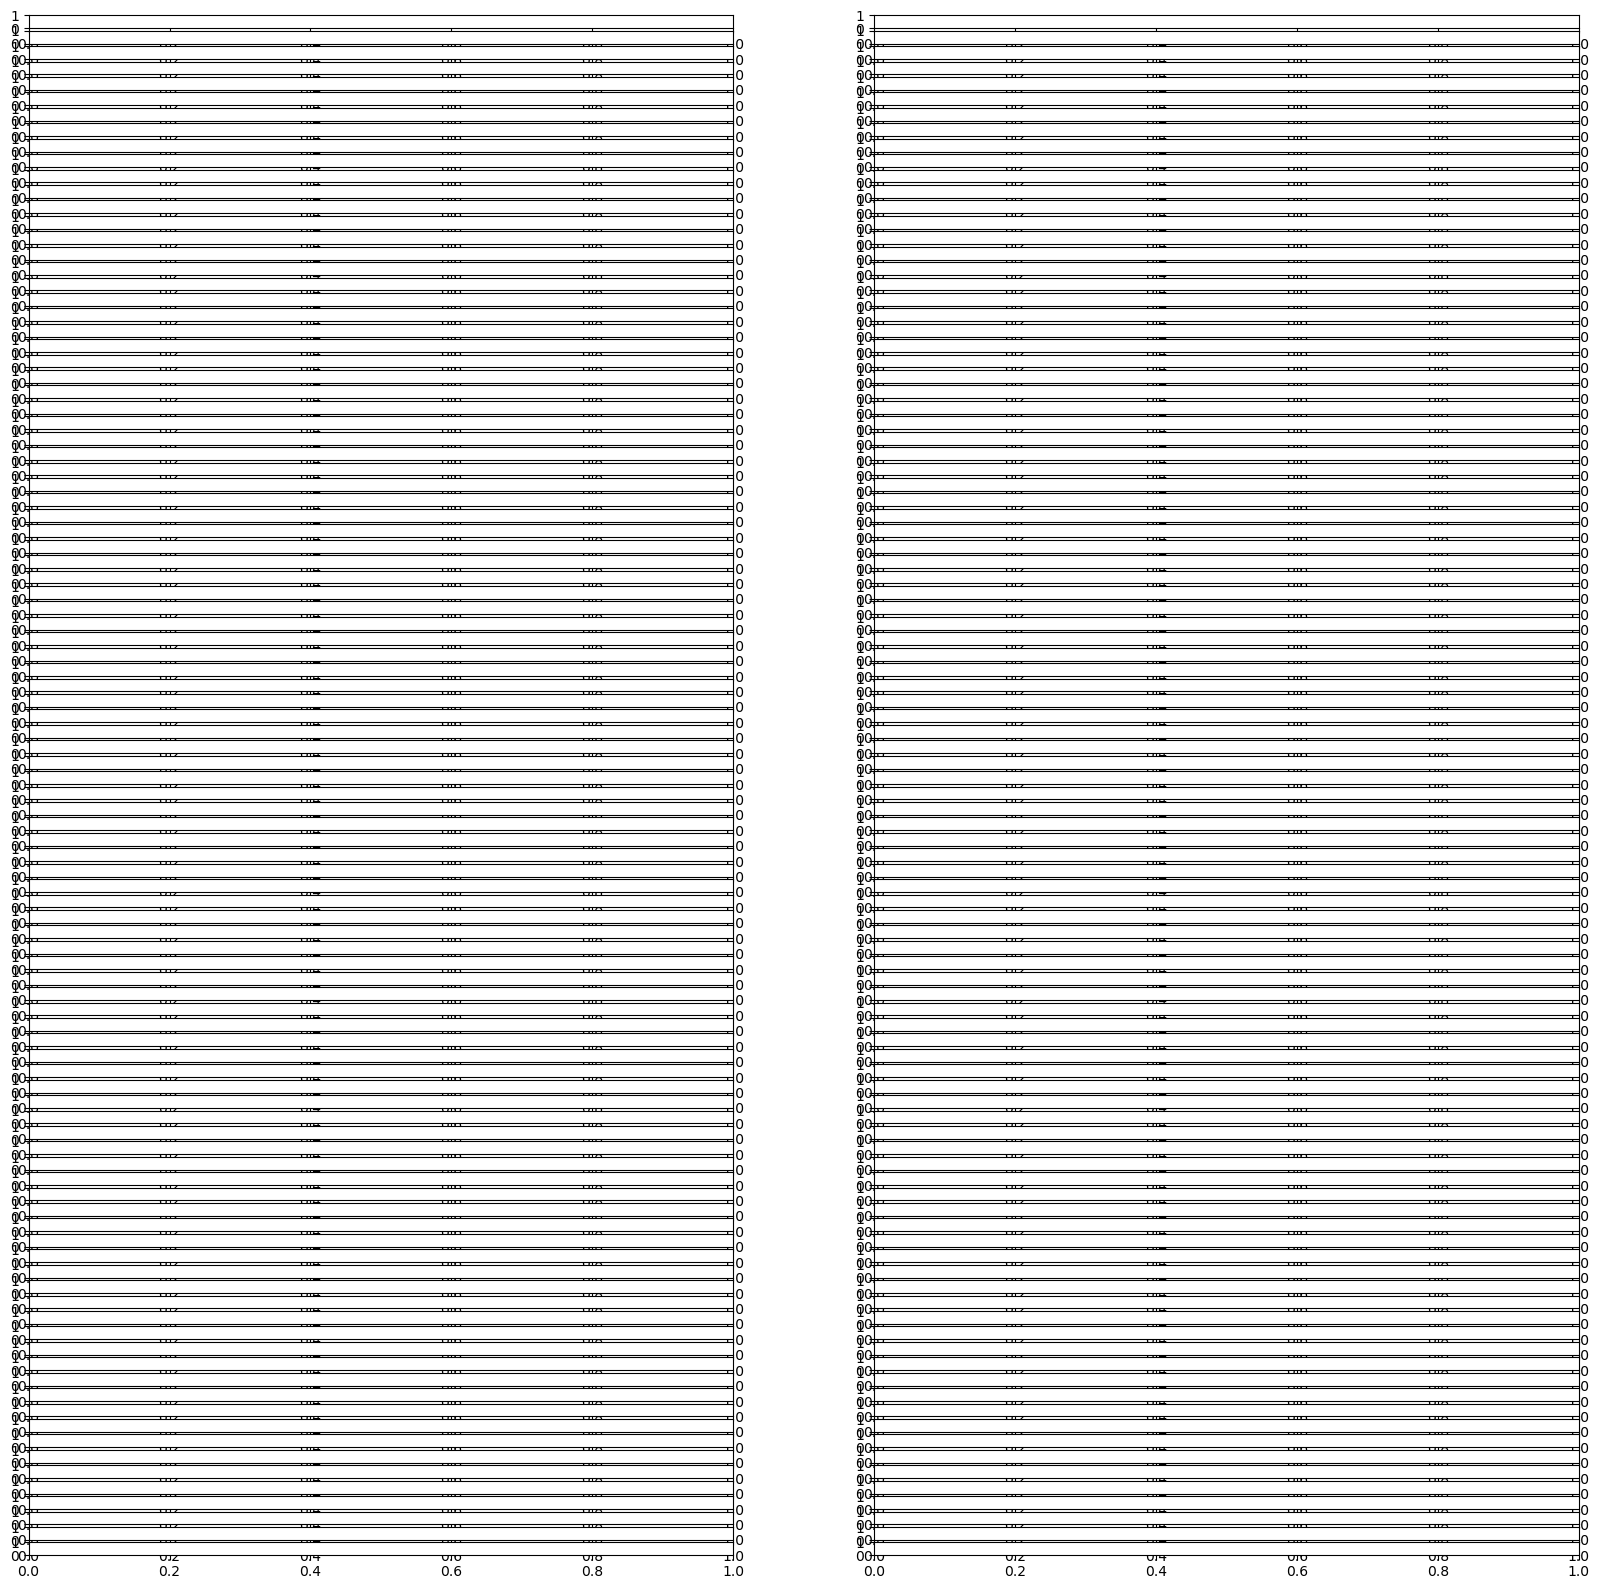

In [10]:
# Opening JSON file
# ------------------------------------ qpsk ------------------------------------
modcod = 'qpsk'
CLUSTERS = 4

timestamps = []
data_type = 'compression'
file_path = modcod + '/' + data_type
fn = os.listdir('../../synth-data/%s' % file_path)
for f in fn:
     timestamps.append(np.load('../../synth-data/%s/%s' % ( file_path,f), allow_pickle=True))
fig, axs = plt.subplots(nrows=len(timestamps), ncols=2, figsize=(20, 20))
result = process(timestamps, data_type, True)
res_df_0 = pd.DataFrame.from_dict(result)

res_df_1 = configuration(data_type='normal', clusters=CLUSTERS, modcod=modcod)
res_df_2 = configuration(data_type='phase_noise', clusters=CLUSTERS, modcod=modcod)
res_df_3 = configuration(data_type='interference', clusters=CLUSTERS, modcod=modcod)

# ------------------------------------ 8psk ------------------------------------

modcod = '8psk'
CLUSTERS = 8

res_df_4 = configuration(data_type='normal', clusters=CLUSTERS, modcod=modcod)
res_df_5 = configuration(data_type='phase_noise', clusters=CLUSTERS, modcod=modcod)
res_df_6 = configuration(data_type='interference', clusters=CLUSTERS, modcod=modcod)

# ------------------------------------ 16apsk ------------------------------------

modcod = '16apsk'
CLUSTERS = 16

res_df_7 = configuration(data_type='normal', clusters=CLUSTERS, modcod=modcod)
res_df_8 = configuration(data_type='phase_noise', clusters=CLUSTERS, modcod=modcod)
res_df_9 = configuration(data_type='interference', clusters=CLUSTERS, modcod=modcod)

# ------------------------------------ 32apsk ------------------------------------

modcod = '32apsk'
CLUSTERS = 32

res_df_10 = configuration(data_type='normal', clusters=CLUSTERS, modcod=modcod)
res_df_11 = configuration(data_type='phase_noise', clusters=CLUSTERS, modcod=modcod)
res_df_12 = configuration(data_type='interference', clusters=CLUSTERS, modcod=modcod)

results = pd.concat([res_df_0, res_df_1, res_df_2, res_df_3, res_df_4, res_df_5, res_df_6, res_df_7, res_df_8,res_df_9, res_df_10, res_df_11,res_df_12])
blobs_encoded = pd.get_dummies(results['blobs'], prefix='blobs')
results = pd.concat([results, blobs_encoded], axis=1)
results = results.drop('blobs', axis=1)

In [11]:
results.head()

,density_avg,density_std,ratio_avg,ratio_std,rotation,class,blobs_4,blobs_8,blobs_16,blobs_32
0,18571.300788,7270.028910,3.527091,0.350604,0.50,compression,True,False,False,False
1,16554.891452,7353.382763,3.796563,0.548940,1.00,compression,True,False,False,False
2,23491.138719,7440.786711,3.350311,0.400275,0.50,compression,True,False,False,False
3,18571.748346,3454.066483,3.533643,0.277818,0.50,compression,True,False,False,False
4,21360.510860,7699.913889,3.450023,0.388860,0.25,compression,True,False,False,False


In [12]:
results.to_csv('training_data.csv')